##Conectar Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Carga de datos y limpieza del dataframe.

In [9]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
from geopy.geocoders import Nominatim

In [10]:
ruta_de_archivos = '/content/drive/MyDrive/UPSO/BigData/Datasets/Dataset_de_ventas'  # Definimos una variable "ruta_de_archivos" que almacena la ruta de la carpeta donde se encuentran los archivos a usar
archivos = os.listdir(ruta_de_archivos)  # La función os.listdir() obtiene una lista de los nombres de los archivos y son almacenados en la variable "archivos"
warnings.simplefilter(action='ignore', category=FutureWarning) # Desactivamos los warnings de futurewarning de pandas

dataframes= {} # Creamos un diccionario vacío que se utilizará para almacenar DataFrames procesados más adelante

for archivo in archivos: # Recorremos cada archivo dentro de "archivos"
    if archivo.endswith('.csv'):  # Asegurarse de que solo se consideren archivos CSV
        mes = archivo.split('_')[3].split('.')[0]  # Obtener el nombre del archivo sin la extensión
        ruta_completa = os.path.join(ruta_de_archivos, archivo)  # Ruta completa al archivo         # ruta_completa = ruta_de_archivos + '/' + archivo
        df = pd.read_csv(ruta_completa)  # Cargar el archivo CSV en un DataFrame
        df_ventas = df.copy()

        df_ventas['Cantidad Pedida'] = pd.to_numeric(df_ventas['Cantidad Pedida'], errors='coerce')  #El errors= 'coerce' transforma los valores no numericos a NaN'
        df_ventas['Precio Unitario'] = pd.to_numeric(df_ventas['Precio Unitario'], errors='coerce')


        df_ventas = df_ventas.loc[~df_ventas['Cantidad Pedida'].isna()]
        df_ventas = df_ventas.loc[~df_ventas['Precio Unitario'].isna()]

        df_ventas = df_ventas.dropna()  # Elimino todos los Nan y me quedo solo con los valores numericos

        df_ventas['Cantidad Pedida'] = df_ventas['Cantidad Pedida'].astype(int)  # Transformo todos los valores numericos al tipo de dato int
        df_ventas['Precio Unitario'] = df_ventas['Precio Unitario'].astype(float)

        dataframes[mes] = df_ventas  # Agregar el DataFrame al diccionario usando el nombre del mes

#variable meses con los nombres en orden para poder ciclar en orden anual los dataframes
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
        'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

In [11]:
def extraer_datos(datos):
  datos['Fecha de Pedido'] = pd.to_datetime(datos['Fecha de Pedido'])
  datos['Hora'] = datos['Fecha de Pedido'].dt.hour
  datos['Dia'] = datos['Fecha de Pedido'].dt.day
  return datos

## 1. Comportamiento de las ventas en los distintos meses:


### ● Total de ventas por mes

In [12]:
# Creo listas para almacenar los totales de ventas y los nombres de los meses
totales_ventas = []

colors=["#FF6B6B",'#FFFF99','#99FF99']

for mes in meses:
    dataframe_mes = dataframes[mes]
    dataframe_mes = extraer_datos(dataframe_mes)

    total_ventas_mes = dataframe_mes['Cantidad Pedida'].count()
    totales_ventas.append(total_ventas_mes)


# Creo el objeto figura con el gráfico de barras
fig = go.Figure()

fig.add_trace(go.Bar(
    x=meses,
    y=totales_ventas,
    marker=dict(color=totales_ventas, colorscale = colors, colorbar=dict(title="Total de ventas", x=1.0, thickness=15)),  # Color y barra de colores
    text=totales_ventas,
    textposition='auto',  # Muestro el valor encima de las barras
))

# Configuro los ejes y los títulos
fig.update_layout(
    title="Total de ventas por mes",
    xaxis=dict(title="Meses"),
    yaxis=dict(title="Total de ventas"),
)

fig.show()

### ● Ingresos totales por mes

In [13]:
ingreso_total_meses=[]
for mes in meses:
    dataframe_mes = dataframes[mes]
    ingresos_mes = dataframe_mes['Precio Unitario'].sum()
    ingreso_total_meses.append(ingresos_mes)

In [15]:
colors = ["#FFE4C4", "#7B68EE", "#FF69B4"]

fig = go.Figure(data=[go.Bar(x=meses, y=ingreso_total_meses,marker=dict(color=ingreso_total_meses, colorscale = colors, colorbar=dict(title="Total Ingresos", x=1.0, thickness=20)))])
fig.update_layout(title='Ingresos totales por mes', xaxis_title='Meses', yaxis_title='Ingresos Totales')

fig.update_traces(
    texttemplate='%{y:.3s}',
    textposition='outside',
)

fig.update_layout(
    yaxis_tickprefix='$',
)

fig.show()

##2. Optimización de la publicidad y patrón de ventas por hora:


### ● Unidades vendidas por hora en diferentes meses

In [17]:
Horas = list(range(24))

fig = go.Figure()

colores = [
    'rgb(135, 206, 235)',  # ENERO
    'rgb(70, 130, 180)',   # FEBRERO
    'rgb(173, 216, 230)',  # MARZO
    'rgb(152, 251, 152)',  # ABRIL
    'rgb(144, 238, 144)',  # MAYO
    'rgb(173, 255, 47)',    # JUNIO
    'rgb(255, 223, 186)',  # JULIO
    'rgb(255, 215, 0)',  # AGOSTO
    'rgb(255, 192, 203)',  # SEPTIEMBRE
    'rgb(244, 164, 96)',  # OCTUBRE
    'rgb(210, 180, 140)',  # NOVIEMBRE
    'rgb(188, 143, 143)'  #DICIEMBRE
]

for mes, color in zip(meses, colores):
    dataframe_mes = dataframes[mes]
    dataframe_mes = extraer_datos(dataframe_mes)  # Reemplaza esto con el procesamiento que necesites
    Ventas_por_hora = dataframe_mes.groupby('Hora')['Cantidad Pedida'].count()

    # Agrego al objeto figura un gráfico de línea con las horas y las ventas por hora
    fig.add_trace(go.Scatter(
        x=Horas,
        y=Ventas_por_hora,
        mode='lines',
        name=mes,
        line=dict(width=2,shape='spline',color=color),
    ))

# Configuro los ejes y los títulos
fig.update_layout(
    title="Unidades vendidas por hora en diferentes meses",
    xaxis=dict(title="Hora", tickvals=Horas),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)

fig.show()

### ● Unidades vendidas en horas específicas

In [18]:
colores = ["rgb(219, 112, 147)", "rgb(70, 130, 180)", "rgb(244, 164, 96)"]

fig = go.Figure()
horas_analizadas = [19, 12, 16]

for i, hora in enumerate(horas_analizadas):
    total_productos_vendidos = []

    for mes in meses:
        dataframe_mes = dataframes[mes]
        dataframe_mes = extraer_datos(dataframe_mes)  # Reemplaza esto con el procesamiento que necesites

        ventas_hora = dataframe_mes[dataframe_mes['Hora'] == hora]

        # Calcular la cantidad total de productos vendidos para la hora actual
        total_productos_vendidos.append(ventas_hora['Cantidad Pedida'].count())

    # Agrego al objeto figura un gráfico de línea con las horas y las ventas por hora
    fig.add_trace(go.Scatter(
        x=meses,
        y=total_productos_vendidos,
        mode='lines',
        name=f'{hora} horas',
        line=dict(width=2, shape='spline', color=colores[i]),  # Asignar el color pastel oscuro correspondiente
    ))

# Configuro los ejes y los títulos
fig.update_layout(
    title="Unidades vendidas en horas específicas",
    xaxis=dict(title="Meses", tickvals=Horas),
    yaxis=dict(title="Unidades vendidas", side="left"),
    legend=dict(y=0.3, yanchor='bottom'),
)

fig.show()

## 3. Distribución de ventas por ubicación:


### ● Cantidad de ventas por Ciudades

In [19]:
resumen_por_ciudad = pd.DataFrame(columns=["Ciudad", "Cantidad Pedida"])
for mes in meses:
    dataframe_mes = dataframes[mes]

    # Dividimos la columna "Dirección de Envío" en función de las comas y extrae la ciudad
    direccion_split = dataframe_mes["Dirección de Envio"].str.split(',')
    dataframe_mes["Ciudad"] = direccion_split.str[1].str.strip()

    # Realizamos un groupby por ciudad y suma la columna "Cantidad Pedida" para el mes actual
    resumen_mes = dataframe_mes.groupby("Ciudad")["Cantidad Pedida"].count().reset_index()

    resumen_por_ciudad = pd.concat([resumen_por_ciudad, resumen_mes], ignore_index=True)

resumen_anual_ciudades = resumen_por_ciudad.groupby("Ciudad")["Cantidad Pedida"].sum().reset_index()

La siguiente celda a veces hay que ejecutarla de nuevo debido a un problema con el tiempo de respuesta.


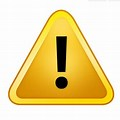

In [23]:
resumen_anual_ciudades["Cantidad Pedida"] = pd.to_numeric(resumen_anual_ciudades["Cantidad Pedida"])

colors = ["#FFE4C4", "#7B68EE", "#FF69B4"]

# Creamos un objeto geocoder de Nominatim
geolocator = Nominatim(user_agent="mi_aplicacion")

latitudes = []
longitudes = []

# Utilizamos geopy para obtener las coordenadas de las ciudades
for ciudad in resumen_anual_ciudades['Ciudad']:
    location = geolocator.geocode(ciudad)

    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        # Si no se encuentra la ubicación
        latitudes.append(None)
        longitudes.append(None)


# Aplicamos una transformación logarítmica a la columna 'Cantidad Pedida'
resumen_anual_ciudades['Tamaño'] = np.log1p(resumen_anual_ciudades['Cantidad Pedida']) #PARA HACER LAS BURBUJAS MAS GRANDES

fig = px.scatter_geo(
    resumen_anual_ciudades,
    lon=longitudes,
    lat=latitudes,
    text='Ciudad',
    size='Tamaño',
    color='Cantidad Pedida',
    color_continuous_scale=colors,
    opacity=0.7,
    hover_name='Ciudad',
    projection='mercator',
 )

fig.update_geos(
    lonaxis_range=[-130, -60],
    lataxis_range=[24, 50],
    showcoastlines=True,
    coastlinecolor="Black",
    showland=True,
    landcolor="white",
)

fig.update_layout(
    title='Cantidad de ventas por Ciudades',
    geo=dict(
        showocean=True,
        oceancolor="LightBlue",
    ),
    coloraxis_colorbar=dict(title='Cantidad Vendida'),
)

fig.show()

### ● Cantidad de ventas por Estado

In [21]:
resumen_por_estado = pd.DataFrame(columns=["Estado", "Cantidad Pedida"])
for mes in meses:
    dataframe_mes = dataframes[mes]

    # Dividimos la columna "Dirección de Envío" en función de las comas y extrae el Estado
    direccion_split = dataframe_mes["Dirección de Envio"].str.split(',')
    dataframe_mes["Estado"] = direccion_split.str[2].str.strip()

    # Realizamos un groupby por estado y suma la columna "Cantidad Pedida" para el mes actual
    resumen_mes = dataframe_mes.groupby("Estado")["Cantidad Pedida"].count().reset_index()

    resumen_por_estado = pd.concat([resumen_por_estado, resumen_mes], ignore_index=True)

    resumen_anual_estado = resumen_por_estado.groupby("Estado")["Cantidad Pedida"].sum().reset_index()

colors= ["#FFD1DC", "#FFA07A", "#FFC0CB", "#FF69B4", "#FF1493"]


resumen_anual_estado[['Estado', 'Código Postal']] = resumen_anual_estado['Estado'].str.split(' ', 1, expand=True) #Separo la columna estado en Estado y Codigo Postal
resumen_agrupado = resumen_anual_estado.groupby('Estado')['Cantidad Pedida'].sum().reset_index()



colors = ["#FFE4C4", "#7B68EE", "#FF69B4"]


fig = go.Figure(go.Choropleth(
    locations=resumen_agrupado['Estado'],
    z=resumen_agrupado['Cantidad Pedida'],
    locationmode="USA-states",
    colorscale=colors,
    showscale=True,
    colorbar_title="Cantidad de Ventas",
))


fig.update_layout(
    title_text='Cantidad de ventas por Estado',
    geo=dict(
        scope="usa",
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
    ),
)

fig.show()

####Para los estados probamos con muchas API gratuitas que les das el Codigo postal y te devuelve las cordenadas, la que mejor funciono fue OpenStreetMap; Aun asi hay algunos CP que no los encontro.
Dejamos comentado una alternativa con esa opcion:

In [25]:
# resumen_por_estado = pd.DataFrame(columns=["Estado", "Cantidad Pedida"])
# for mes in meses:
#     dataframe_mes = dataframes[mes]

#     # Dividimos la columna "Dirección de Envío" en función de las comas y extrae el Estado
#     direccion_split = dataframe_mes["Dirección de Envio"].str.split(',')
#     dataframe_mes["Estado"] = direccion_split.str[2].str.strip()

#     # Realizamos un groupby por estado y suma la columna "Cantidad Pedida" para el mes actual
#     resumen_mes = dataframe_mes.groupby("Estado")["Cantidad Pedida"].count().reset_index()

#     resumen_por_estado = pd.concat([resumen_por_estado, resumen_mes], ignore_index=True)

#     resumen_anual_estado = resumen_por_estado.groupby("Estado")["Cantidad Pedida"].sum().reset_index()

# import requests
# def obtener_coordenadas(codigo_postal):
#     # URL de la API de Nominatim (OpenStreetMap)
#     url = f"https://nominatim.openstreetmap.org/search?postalcode={codigo_postal}&countrycodes=US&format=json&limit=1"

#     response = requests.get(url)

#     if response.status_code == 200:
#         data = response.json()
#         if data:
#             lat = float(data[0]['lat'])
#             lon = float(data[0]['lon'])
#             return lat, lon
#     return None

# latitudes = []
# longitudes = []
# codigos_postales = [estado.split()[1] for estado in resumen_anual_estado['Estado']]

# # Utiliza la función para obtener las coordenadas
# for codigo_postal in codigos_postales:
#     coordenadas = obtener_coordenadas(codigo_postal)
#     if coordenadas:
#         latitudes.append(coordenadas[0])
#         longitudes.append(coordenadas[1])
#     else:
#         latitudes.append(None)
#         longitudes.append(None)


# resumen_anual_estado['Latitud'] = latitudes
# resumen_anual_estado['Longitud'] = longitudes


# resumen_anual_estado["Cantidad Pedida"] = pd.to_numeric(resumen_anual_estado["Cantidad Pedida"])


# fig = go.Figure()

# fig.add_trace(
#     go.Scattergeo(
#         lon=resumen_anual_estado['Longitud'],
#         lat=resumen_anual_estado['Latitud'],
#         text=resumen_anual_estado['Estado'],
#         mode='markers',
#         marker=dict(
#             size=resumen_anual_estado['Cantidad Pedida'] / 1000,
#             opacity=0.7,
#             colorscale='Viridis',
#             color=resumen_anual_estado['Cantidad Pedida'],
#             colorbar=dict(title='Cantidad Pedida')
#         )
#     )
# )

# fig.update_geos(
#     projection_type="mercator",
#     showcoastlines=True,
#     coastlinecolor="Black",
#     showland=True,
#     landcolor="white",
# )

# fig.update_layout(
#     title='Cantidad Pedida por Estados',
#     geo=dict(
#         scope="world",  # Ajusta el alcance del mapa a Estados Unidos
#         showocean=True,
#         oceancolor="LightBlue",
#     )
# )


# fig.show()

### ● ¿Existe variación en las ventas por estado a lo largo de los meses?


In [26]:
resumen_total = pd.DataFrame(columns=["Mes", "Estado", "Cantidad Pedida"])

for mes in meses:
    dataframe_mes = dataframes[mes]
    # Dividimos la columna "Dirección de Envío" en función de las comas y extrae el Estado
    direccion_split = dataframe_mes["Dirección de Envio"].str.split(',')
    dataframe_mes["Estado"] = direccion_split.str[2].str.strip()


    dataframe_mes["Mes"] = mes

    # Concatenamos el dataframe_mes al DataFrame resumen_total
    resumen_total = pd.concat([resumen_total, dataframe_mes], ignore_index=True)


resumen_total['Mes'] = pd.Categorical(resumen_total['Mes'], categories=meses, ordered=True) #hacemos que la columnna mes sea una columna categorizada segun los meses en orden,
                                                                                            #sino el groupby ordena los meses en orden alfabetico
resumen_total = resumen_total.groupby(["Estado","Mes"])["Cantidad Pedida"].count().reset_index()
resumen_total[['Estado', 'Código Postal']] = resumen_total['Estado'].str.split(' ', 1, expand=True) #Separamos la columna estado en Estado y Codigo Postal
resumen_total = resumen_total.groupby(["Estado","Mes"])["Cantidad Pedida"].sum().reset_index()


In [ ]:
resumen_total['Cantidad Pedida'] = pd.to_numeric(resumen_total['Cantidad Pedida'], errors='coerce')

colors= [
    "#FFB6C1",  # Rosa claro
    "#FFD700",  # Amarillo
    "#98FB98",  # Verde claro
    "#87CEEB",  # Azul cielo
    "#FFA07A",  # Salmón claro
    "#FF69B4",  # Rosa brillante
]


fig = px.scatter(resumen_total, x="Mes", y="Estado", size="Cantidad Pedida", color="Cantidad Pedida",
                 title="Cantidad pedida por mes y Estado",color_continuous_scale=colors,)

fig.update_xaxes(title="Meses")
fig.update_yaxes(title="Estado")
fig.update_layout(coloraxis_colorbar_title="Cantidad Vendida")

fig.show()







##4. Análisis del producto más vendido:


### ● Cantidades vendidas por mes del producto más vendido

In [27]:
meses_mas_vendidos = []
productos_mas_vendidos = []
cantidades_mas_vendidas = []

for mes in meses:
    dataframe_mes = dataframes[mes]

    ventas_por_producto = dataframe_mes.groupby("Producto")["Cantidad Pedida"].sum()

    producto_mas_vendido = ventas_por_producto.idxmax()
    cantidad_mas_vendida = ventas_por_producto.max()

    meses_mas_vendidos.append(mes)
    productos_mas_vendidos.append(producto_mas_vendido)
    cantidades_mas_vendidas.append(cantidad_mas_vendida)

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=meses_mas_vendidos,
    y=cantidades_mas_vendidas,
    text=[''] * len(meses_mas_vendidos),
    hovertext=productos_mas_vendidos,
    fill='tozeroy',
    mode='lines+markers',
    line=dict(color="#7B68EE", width=3),
    marker=dict(size=10, color="#FFE4C4", line=dict(width=2, color='white')),
    hoverinfo='x+y+text',
))


fig.update_layout(
    title='Cantidades vendidas por mes del producto más vendido',
    xaxis=dict(title='Meses'),
    yaxis=dict(title='Cantidad Vendida'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
)


fig.show()

##5. Tendencia ventas:


### ● Unidades vendidas por día en diferentes meses

In [31]:
Dias = list(range(1, 32))


colors=[
    [0.0, '#f3a8c2'],   # Rosa pastel
    [0.25, '#f6d1de'],  # Rosa claro
    [0.5, '#61d1cc'],   # Azul pastel
    [0.75, '#b0f6f2'],  # Azul claro
    [1.0, '#397ed4'],   # Amarillo pastel
]

data = []

for mes in meses:
    dataframe_mes = dataframes[mes]
    Ventas_por_dia = dataframe_mes.groupby('Dia')['Cantidad Pedida'].count().tolist()
    data.append(Ventas_por_dia)


fig = go.Figure(data=go.Heatmap(
    z=data,
    x=Dias,
    y=meses,
    customdata=data,
    hovertemplate='Día: %{x}<br>Mes: %{y}<br>Cantidad Pedida: %{customdata}<extra></extra>',
    colorscale=colors,
))


fig.update_layout(
    title="Unidades vendidas por día en diferentes meses",
)
fig.update_yaxes(title_text='Meses')
fig.update_xaxes(title_text='Dias')

fig.show()

### ● Distribución de ventas por día de la semana

In [30]:
dataFrameAnio = pd.DataFrame()

for mes in meses:
    dataframe_mes = dataframes[mes]
    dataframe_mes = dataframe_mes.sort_values(by=['Dia'])
    # Concatenamos los dataframes
    dataFrameAnio = pd.concat([dataFrameAnio, dataframe_mes], ignore_index=True)

#Función para calcular el día de la semana
def calcular_dia_semana(fecha_pedido):
    return fecha_pedido.strftime("%A")

 #Aplicamos la función para calcular el día de la semana y agregarlo como una nueva columna
dataFrameAnio['Dia de la Semana'] = dataFrameAnio['Fecha de Pedido'].apply(calcular_dia_semana)

In [32]:
ventas_por_dia_semana = dataFrameAnio.groupby('Dia de la Semana')['Cantidad Pedida'].count()

traduccion_dias = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

# Aplicamos la traducción
ventas_por_dia_semana.index = ventas_por_dia_semana.index.map(traduccion_dias)



colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0', '#ffb3e6', '#c2f0c2']

fig = go.Figure(data=[go.Pie(labels=ventas_por_dia_semana.index, values=ventas_por_dia_semana,
                             marker=dict(colors=colors, line=dict(color='black', width=2)),
                             opacity=0.7
                            )])


fig.update_layout(
    title='Distribución de ventas por día de la semana',
    title_font=dict(size=20),
    showlegend=True,
    legend=dict(x=0.7, y=0.1),
)


fig.update_traces(textinfo='percent+label', textfont_size=14)

fig.show()

##6. Impacto de eventos especiales en las ventas:


### ● Ventas en días cercanos a eventos especiales

In [34]:
# Filtramos las fechas de interés
fechas_interesantes = pd.date_range(start='2019-12-25', end='2019-12-31', freq='D')
# Filtramos el DataFrame para incluir solo las filas correspondientes a las fechas de interés
ventas_interesantes = dataFrameAnio[dataFrameAnio['Fecha de Pedido'].dt.floor('D').isin(fechas_interesantes)]
ventas_interesantes = ventas_interesantes.groupby(ventas_interesantes['Fecha de Pedido'].dt.date)['Cantidad Pedida'].count().reset_index()


fechas_interesantes2 = pd.date_range(start='2019-12-18', end='2019-12-24', freq='D')
ventas_interesantes2 = dataFrameAnio[dataFrameAnio['Fecha de Pedido'].dt.floor('D').isin(fechas_interesantes2)]
ventas_interesantes2 = ventas_interesantes2.groupby(ventas_interesantes2['Fecha de Pedido'].dt.date)['Cantidad Pedida'].count().reset_index()


fechas_interesantes3 = pd.date_range(start='2019-02-08', end='2019-02-14', freq='D')
ventas_interesantes3 = dataFrameAnio[dataFrameAnio['Fecha de Pedido'].dt.floor('D').isin(fechas_interesantes3)]
ventas_interesantes3 = ventas_interesantes3.groupby(ventas_interesantes3['Fecha de Pedido'].dt.date)['Cantidad Pedida'].count().reset_index()


fechas_interesantes4 = pd.date_range(start='2019-11-21', end='2019-11-28', freq='D')
ventas_interesantes4 = dataFrameAnio[dataFrameAnio['Fecha de Pedido'].dt.floor('D').isin(fechas_interesantes4)]
ventas_interesantes4 = ventas_interesantes4.groupby(ventas_interesantes4['Fecha de Pedido'].dt.date)['Cantidad Pedida'].count().reset_index()


In [35]:
# Creamos un gráfico de líneas para la primera semana
fig_semana1 = go.Figure()
fig_semana1.add_trace(go.Scatter(x=ventas_interesantes['Fecha de Pedido'], y=ventas_interesantes['Cantidad Pedida'], mode='lines', name='Año Nuevo', marker_color='#fdcae1'))
fig_semana1.update_layout(
    title='Variación de Ventas Previo a Año Nuevo',
    xaxis=dict(title='Fecha de Pedido'),
    yaxis=dict(title='Cantidad Pedida'),
)

# Creamos un gráfico de líneas para la segunda semana
fig_semana2 = go.Figure()
fig_semana2.add_trace(go.Scatter(x=ventas_interesantes2['Fecha de Pedido'], y=ventas_interesantes2['Cantidad Pedida'], mode='lines', name='Noche Buena', marker_color='#fdfd96'))
fig_semana2.update_layout(
    title='Variación de Ventas Previo Navidad',
    xaxis=dict(title='Fecha de Pedido'),
    yaxis=dict(title='Cantidad Pedida'),
)

# Creamos un gráfico de líneas para la tercera semana
fig_semana3 = go.Figure()
fig_semana3.add_trace(go.Scatter(x=ventas_interesantes3['Fecha de Pedido'], y=ventas_interesantes3['Cantidad Pedida'], mode='lines', name='San Valentin', marker_color='#84b6f4'))
fig_semana3.update_layout(
    title='Variación de Ventas Previo San Valentín',
    xaxis=dict(title='Fecha de Pedido'),
    yaxis=dict(title='Cantidad Pedida'),
)

# Creamos un gráfico de líneas para la cuarta semana
fig_semana4 = go.Figure()
fig_semana4.add_trace(go.Scatter(x=ventas_interesantes4['Fecha de Pedido'], y=ventas_interesantes4['Cantidad Pedida'], mode='lines', name='Dia de la Madre', marker_color='#b0f2c2'))
fig_semana4.update_layout(
    title='Variación de Ventas Previo el Dia de la Madre',
    xaxis=dict(title='Fecha de Pedido'),
    yaxis=dict(title='Cantidad Pedida'),
)


# Creamos subplots en dos filas y una columna
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.3)

# Agregamos los gráficos
fig.add_trace(fig_semana1.data[0], row=1, col=1)
fig.add_trace(fig_semana2.data[0], row=1, col=2)
fig.add_trace(fig_semana3.data[0], row=2, col=1)
fig.add_trace(fig_semana4.data[0], row=2, col=2)


fig.update_xaxes(title_text='Fecha de Pedido', row=1, col=1)
fig.update_xaxes(title_text='Fecha de Pedido', row=1, col=2)


fig.update_yaxes(title_text='Cantidad Vendida', row=1, col=1)
fig.update_yaxes(title_text='Cantidad Vendida', row=2, col=1)

fig.update_layout(
    title='Ventas en días cercanos a eventos especiales',
    title_x=0.5,
)


fig.show()

## 7. Pregunta adicional



### ● Cantidad vendida por estación y mes

In [37]:
# Definimos una función para asignar la estación según la fecha de pedido
def asignar_estacion(fecha_pedido):
    mes = fecha_pedido.month
    dia = fecha_pedido.day

    if (mes == 12 and dia >= 21) or (mes == 1) or (mes == 2) or (mes == 3 and dia <= 20):  #Invierno (21 de diciembre – 20 de marzo)
        return 'Invierno'
    elif (mes == 3 and dia >= 21) or (mes == 4) or (mes == 5) or (mes == 6 and dia <= 21): #Primavera (20 de marzo – 21 de junio)
        return 'Primavera'
    elif (mes == 6 and dia >= 22) or (mes == 7) or (mes == 8) or (mes == 9 and dia <= 22): #Verano (21 de junio – 22 de septiembre)
        return 'Verano'
    else:
        return 'Otoño'                                                                     #Otoño (22 de septiembre – 21 de diciembre)

# Creamos un DataFrame para almacenar los datos de estaciones y meses
estaciones_meses = pd.DataFrame(columns=['Estacion', 'Mes', 'Cantidad Pedida'])
from datetime import datetime

# Recorremos los DataFrames por mes y asigna la estación según la fecha de pedido
for mes in meses:
    dataframe_mes = dataframes[mes]
    dataframe_mes['Estacion'] = dataframe_mes['Fecha de Pedido'].apply(asignar_estacion) #asignar_estacion() a la nueva columna Estacion segun la columna Fecha Pedido
    estacion_data = dataframe_mes.groupby(['Estacion', 'Mes'])['Cantidad Pedida'].count().reset_index()
    estaciones_meses = estaciones_meses.append(estacion_data, ignore_index=True)

# Agrupamos los datos por estación y mes para obtener la suma total de cantidades pedidas
estaciones_meses_totales = estaciones_meses.groupby(['Estacion', 'Mes'])['Cantidad Pedida'].sum().reset_index()


# Diccionario que asigna colores a cada estación
colores_estaciones = {
    'Invierno': '#81c9fa',
    'Otoño': '#ffda89',
    'Primavera': '#8dfda1',
    'Verano': '#ff6961',
}


# Asignamos un color a cada fila en el DataFrame basado en la columna 'Estacion'
estaciones_meses_totales['Color'] = estaciones_meses_totales['Estacion'].map(colores_estaciones)

#--------------------------------------------------------------------------------------------------------------------

# Orden personalizado para las estaciones y los meses
estaciones_orden = ['Invierno', 'Primavera', 'Verano', 'Otoño']
meses_orden = ['Diciembre', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre']

# Aplicamos el orden personalizado a las columnas correspondientes
estaciones_meses_totales['Estacion'] = pd.Categorical(estaciones_meses_totales['Estacion'], categories=estaciones_orden, ordered=True)
estaciones_meses_totales['Mes'] = pd.Categorical(estaciones_meses_totales['Mes'], categories=meses_orden, ordered=True)


# Ordenamos el DataFrame primero por Estacion y luego por Mes
estaciones_meses_totales = estaciones_meses_totales.sort_values(by=['Estacion', 'Mes'])

 # Identificamos la fila correspondiente a Diciembre en la estación de otoño

fila_diciembre_otoño = estaciones_meses_totales[(estaciones_meses_totales['Estacion'] == 'Otoño') & (estaciones_meses_totales['Mes'] == 'Diciembre')]

 # Eliminamos la fila de Diciembre en la estación de otoño
estaciones_meses_totales = estaciones_meses_totales.drop(fila_diciembre_otoño.index)

# Agregamos la fila de Diciembre al final
estaciones_meses_totales = estaciones_meses_totales.append(fila_diciembre_otoño)

# Reiniciamos los índices del DataFrame
estaciones_meses_totales = estaciones_meses_totales.reset_index(drop=True)

#Todo este ultimo ordenadamiento lo hicimos para poder ordenar el grafico Sunburst por 'Estacion' y luego adentro de cada estacion ordenarlo por 'Mes', ya que hay meses que comparten dos estaciones.
#Lamentablemente el grafico SunBurst ordena los datos segun el parametro "Values", lo que hizo que los datos se ordenen en funcion de la 'Cantidad Pedida'.
#En la siguiente tabla estan los datos formateados en el orden que queriamos ordenarlos:
estaciones_meses_totales



,Estacion,Mes,Cantidad Pedida,Color
0,Invierno,Diciembre,8892,#81c9fa
1,Invierno,Enero,9681,#81c9fa
2,Invierno,Febrero,11986,#81c9fa
3,Invierno,Marzo,9778,#81c9fa
4,Primavera,Marzo,5376,#8dfda1
5,Primavera,Abril,18289,#8dfda1
6,Primavera,Mayo,16554,#8dfda1
7,Primavera,Junio,9571,#8dfda1
8,Verano,Junio,3985,#ff6961
9,Verano,Julio,14291,#ff6961


In [39]:
fig = px.sunburst(
    estaciones_meses_totales,
    path=['Estacion', 'Mes'],
    values='Cantidad Pedida',
    color='Estacion',
    color_discrete_map=colores_estaciones,
    branchvalues='total',
)


fig.update_layout(
    title='Cantidad vendida por estación y mes',
    margin = dict(t=30, l=0, r=0, b=0),
)

fig.update_traces(
    hovertemplate='<b>Cantidad Pedida:</b> %{value}<extra></extra>',
     insidetextorientation='radial',  # Esto rota el texto
)


fig.update_coloraxes(showscale=False)

fig.show()